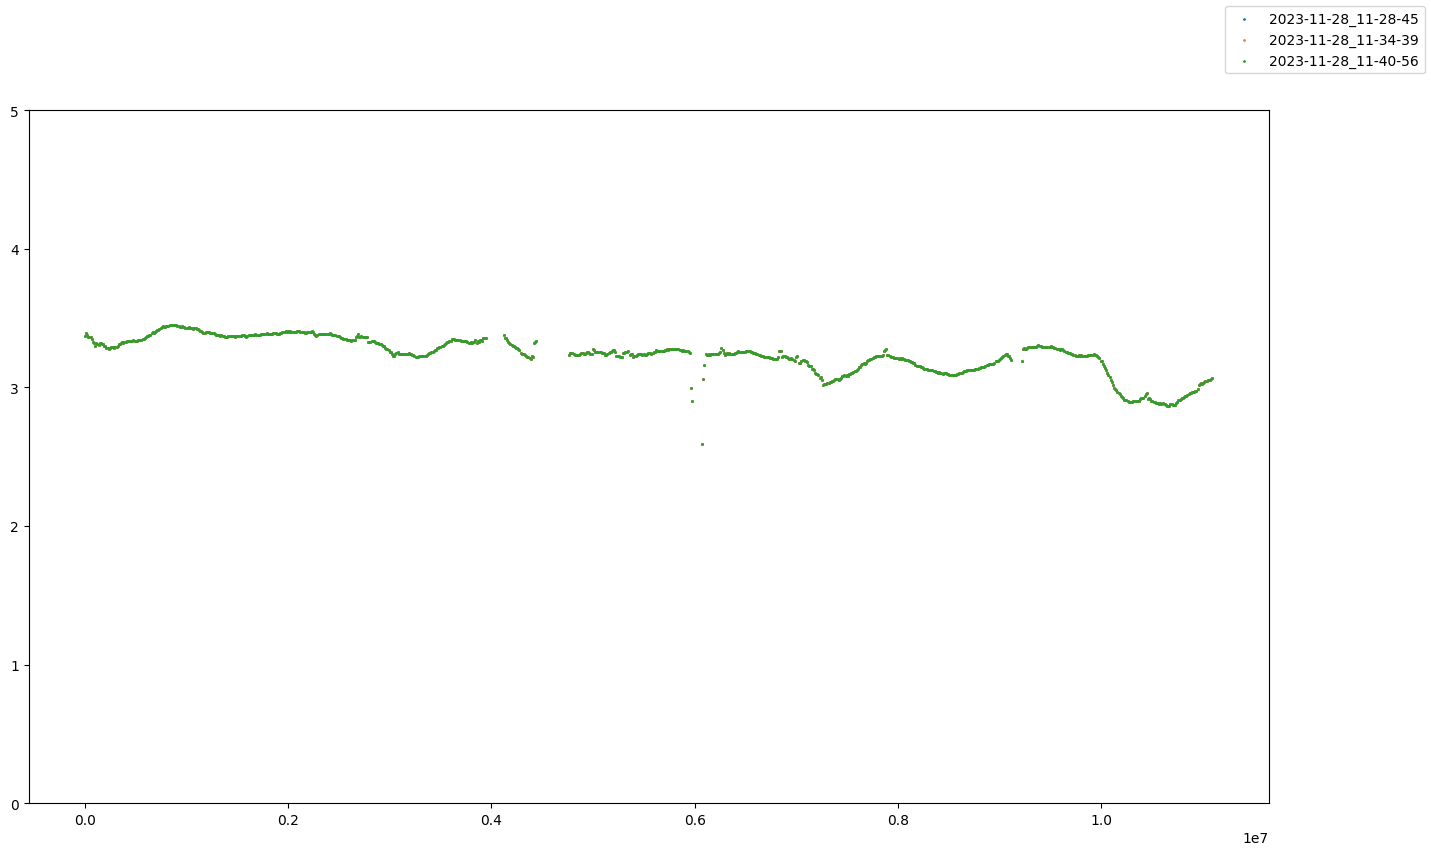

In [3]:
### Make a plot that shows the pupil size over time and average for first page and last page

from datetime import datetime
import os
from utils import Events
import matplotlib.pyplot as plt

EYE_TRACKER_FOLDER = "eye_tracker_data/"

participant_ids = [98]

fig, ax = plt.subplots(figsize=(16, 9))
# Make sure y-axis starts at 0
ax.set_ylim([0, 5])

for participant in participant_ids:
    events = (
        Events.select()
        .where(Events.participant_id == participant)
        .where(Events.event.in_(["OPEN_BOOK", "CLOSE_BOOK"]))
        .order_by(Events.time)
    )
    for event in events:
        if event.event == "OPEN_BOOK":
            start_time = event.time
            continue
        elif event.event == "CLOSE_BOOK":
            end_time = event.time

        timestamp_formatted = datetime.fromtimestamp(start_time).strftime(
            "%Y-%m-%d_%H-%M-%S"
        )

        gaze_data_filename = f"[{str(participant)}]-{timestamp_formatted}.json"
        gaze_data_filepath = os.path.join(EYE_TRACKER_FOLDER, gaze_data_filename)
        # Read the file
        import json

        with open(gaze_data_filepath, "r") as f:
            gaze_data = json.load(f)["data"]

        ### TODO: Get only the data from the start_time to end_time

        # Do calculation (gaze["left_pupil_diameter"] + gaze["right_pupil_diameter"]) / 2
        # on every gaze point and be None safe
        pupil_sizes = [
            (gaze["left_pupil_diameter"] + gaze["right_pupil_diameter"]) / 2
            if gaze["left_pupil_diameter"] is not None
            and gaze["right_pupil_diameter"] is not None
            else None
            for gaze in gaze_data
        ][:1000]

        time_data = [
            gaze["system_time_stamp"] - gaze_data[0]["system_time_stamp"]
            for gaze in gaze_data
        ][:1000]

        ax.scatter(time_data, pupil_sizes, label=timestamp_formatted, s=1)

fig.legend()